In [1]:
import os 
os.chdir("../..")

In [2]:
import numpy as np
import json
from detectron2.structures import BoxMode
import pandas as pd
import geopandas as gpd
import cv2
import matplotlib.pyplot as plt


from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import sys
sys.path.insert(1, '/home/h/uav-forests')
from src.utils.dataset import split_train_val_test, DatasetsDictsGenerator, register_detectron2_datasets
import pickle

In [3]:
import os
cwd = os.getcwd()
cwd

'/home/h/uav-forests'

In [4]:
if os.path.exists("data/szprotawa_splits.pkl"):
    with open("./data/szprotawa/szprotawa_splits.pkl", "rb") as f:
        splits = pickle.load(f)
else:
    samples = pd.read_pickle("./data/szprotawa/szprotawa_patches_256_rgn/annotation.pkl")["patch_number"].unique()
    splits = split_train_val_test(samples, 0.7, 0.15, 0.15)
    with open("./data/szprotawa/szprotawa_splits.pkl", "wb") as f:
        pickle.dump(splits, f)


register_detectron2_datasets("szprotawa", "./data/szprotawa/szprotawa_patches_256_rgn/", 
                                      splits, min_bbox_area=200, 
                                      limits={"train": -1, "val": -1, "test": -1})

In [5]:
!ls data/szprotawa/

szprotawa_patches_256	   szprotawa_patches_256_rnb
szprotawa_patches_256_rgn  szprotawa_splits.pkl


In [6]:
meta = MetadataCatalog.get("szprotawa_train")
meta

Metadata(name='szprotawa_train', thing_classes=['SickTrees'])

In [7]:
# dataset_dicts = get_szprotawa_dicts("data/szprotawa_patches_256/")

dataset_dicts = DatasetCatalog.get("szprotawa_val")
len(dataset_dicts)

225

In [8]:
d = DatasetsDictsGenerator("./data/szprotawa/szprotawa_patches_256_rgn/",
                             splits['val'],
                             200,
                             100)()
len(d)

93

In [9]:
d[0]

{'file_name': './data/szprotawa/szprotawa_patches_256_rgn/patch_484.png',
 'image_id': 484,
 'height': 256,
 'width': 256,
 'annotations': [{'bbox': [200, 49, 255, 107],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 0}]}

In [10]:
splits.keys()

dict_keys(['train', 'val', 'test'])

./data/szprotawa/szprotawa_patches_256_rgn/patch_16398.png


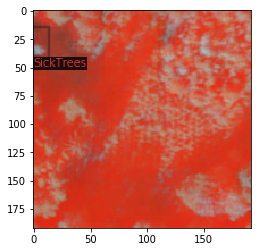

In [11]:
smpl = np.random.choice(dataset_dicts, 1)
for d in smpl:
    print(d["file_name"])
    img = cv2.imread(d["file_name"])[:, :, ::-1]
    visualizer = Visualizer(img, metadata=meta, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [12]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir tboard_logs

In [13]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [14]:
from datetime import datetime

In [15]:
# cfg = get_cfg()

# cfg.OUTPUT_DIR = f"./tboard_logs/retinanet_test_{datetime.now().isoformat().rsplit(':', 1)[0]}/"
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

# cfg.DATASETS.TRAIN = ("szprotawa_train",)
# cfg.DATASETS.TEST = ("szprotawa_val",)
# cfg.DATALOADER.NUM_WORKERS = 4

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

# cfg.SOLVER.IMS_PER_BATCH = 4
# cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
# cfg.SOLVER.MAX_ITER = 30_000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.SOLVER.CHECKPOINT_PERIOD = 250


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
# cfg.MODEL.RETINANET.NUM_CLASSES = 1  # only has one class (ballon)

# cfg.TEST.EVAL_PERIOD = 500 #200
# cfg.TEST.DETECTIONS_PER_IMAGE = 10

# cfg.VIS_PERIOD = 100

In [16]:
cfg = get_cfg()

cfg.OUTPUT_DIR = "tboard_logs/retinanet_rgb/"
# cfg.OUTPUT_DIR = f"./tboard_logs/retinanet_test_{datetime.now().isoformat().rsplit(':', 1)[0]}/"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("szprotawa_train",)
cfg.DATASETS.TEST = ("szprotawa_val", )
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 90_000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.CHECKPOINT_PERIOD = 4000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.RETINANET.NUM_CLASSES = 1  # only has one class (ballon)

cfg.TEST.EVAL_PERIOD = 20000 #200
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 100

Loading config /home/h/anaconda3/envs/geopython37/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [17]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


class Trainer(DefaultTrainer):
    
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR+f"/eval/{dataset_name}")


In [18]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

ax_mem: 2546M
[02/25 12:29:25 d2.utils.events]: eta: 7:20:50  iter: 18299  total_loss: 0.060  loss_cls: 0.027  loss_box_reg: 0.033  time: 0.3663  data_time: 0.0066  lr: 0.000100  max_mem: 2546M
[02/25 12:29:32 d2.utils.events]: eta: 7:20:40  iter: 18319  total_loss: 0.063  loss_cls: 0.027  loss_box_reg: 0.032  time: 0.3663  data_time: 0.0062  lr: 0.000100  max_mem: 2546M
[02/25 12:29:39 d2.utils.events]: eta: 7:20:39  iter: 18339  total_loss: 0.071  loss_cls: 0.034  loss_box_reg: 0.035  time: 0.3663  data_time: 0.0060  lr: 0.000100  max_mem: 2546M
[02/25 12:29:47 d2.utils.events]: eta: 7:20:25  iter: 18359  total_loss: 0.051  loss_cls: 0.025  loss_box_reg: 0.028  time: 0.3663  data_time: 0.0060  lr: 0.000100  max_mem: 2546M
[02/25 12:29:54 d2.utils.events]: eta: 7:20:22  iter: 18379  total_loss: 0.060  loss_cls: 0.024  loss_box_reg: 0.034  time: 0.3663  data_time: 0.0065  lr: 0.000100  max_mem: 2546M
[02/25 12:30:02 d2.utils.events]: eta: 7:20:28  iter: 18399  total_loss: 0.067  loss_c

AssertionError: Results do not correspond to current coco set

In [ ]:
cfg.OUTPUT_DIR

In [ ]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("szprotawa_val", )
# cfg.TEST.SCORE_THRESHOLD = 0.3
# cfg.TEST.SCORE_THRESH_TEST = 0.3
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3


cfg.TEST.DETECTIONS_PER_IMAGE = 10
predictor = DefaultPredictor(cfg)

predictor.cfg["TEST"]

In [ ]:
with open(cfg.OUTPUT_DIR + "/config.yml", "w") as f:
    f.write(cfg.dump())

In [ ]:
1+2

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("szprotawa_test")

In [ ]:
import time
for d in np.random.choice(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:,:,::-1].copy(),
                   metadata=meta, 
                   scale=0.8)
    vis = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    f, a = plt.subplots(1,3, figsize=(21,7))
    a[0].imshow(im[:,:,::-1])
    a[1].imshow(vis.get_image())
    
    v = Visualizer(im[:,:,::-1].copy(),
                   metadata=meta, 
                   scale=0.8)
    vis = v.draw_dataset_dict(d)
    a[2].imshow(vis.get_image())

In [ ]:
_ = register_detectron2_datasets("szprott", "./data/szprotawa_patches_256/", 0.7, 0.15, 0.15, 100, {'test': splits['test'][:500]})

In [ ]:
from detectron2.evaluation import DatasetEvaluator, COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader



evaluator = COCOEvaluator("szprotawa_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "szprotawa_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

In [ ]:
1+2

In [ ]:
outputs.keys()